In [81]:
from region_detection import *
from commonfunctions import *

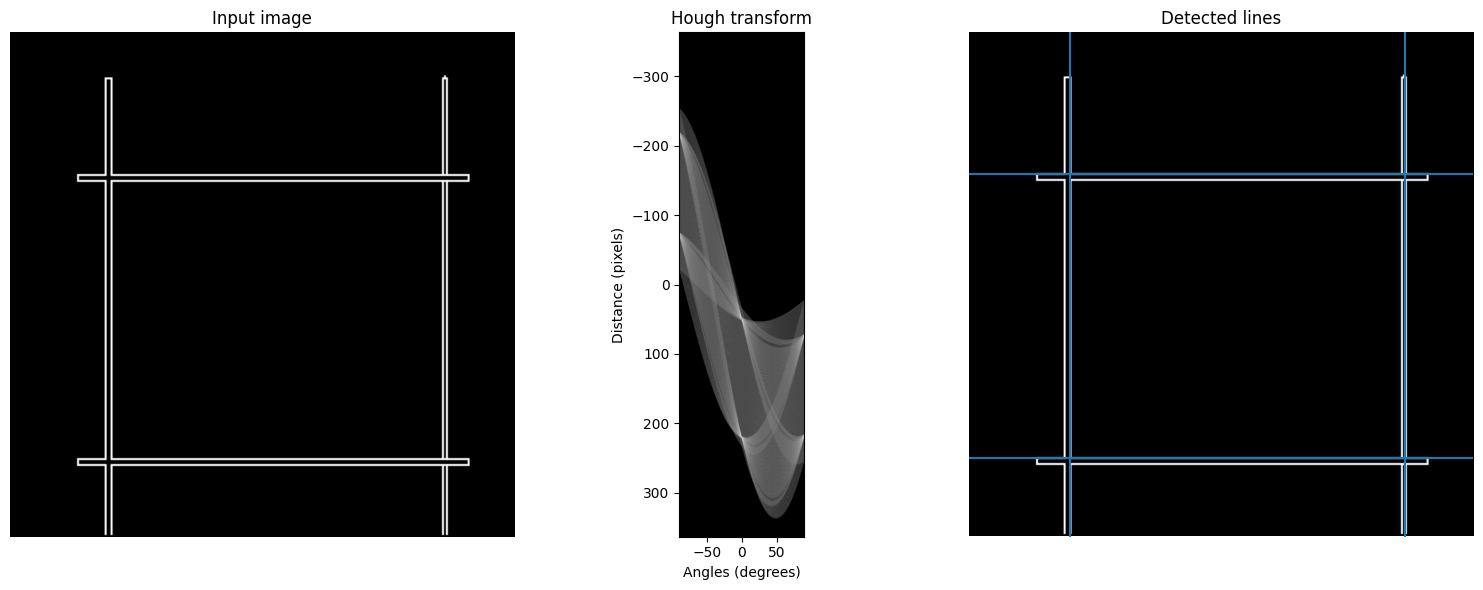

[(221.0, 72.0), (221.0, 216.0), (51.0, 72.0), (51.0, 216.0)]
72 216
51 221


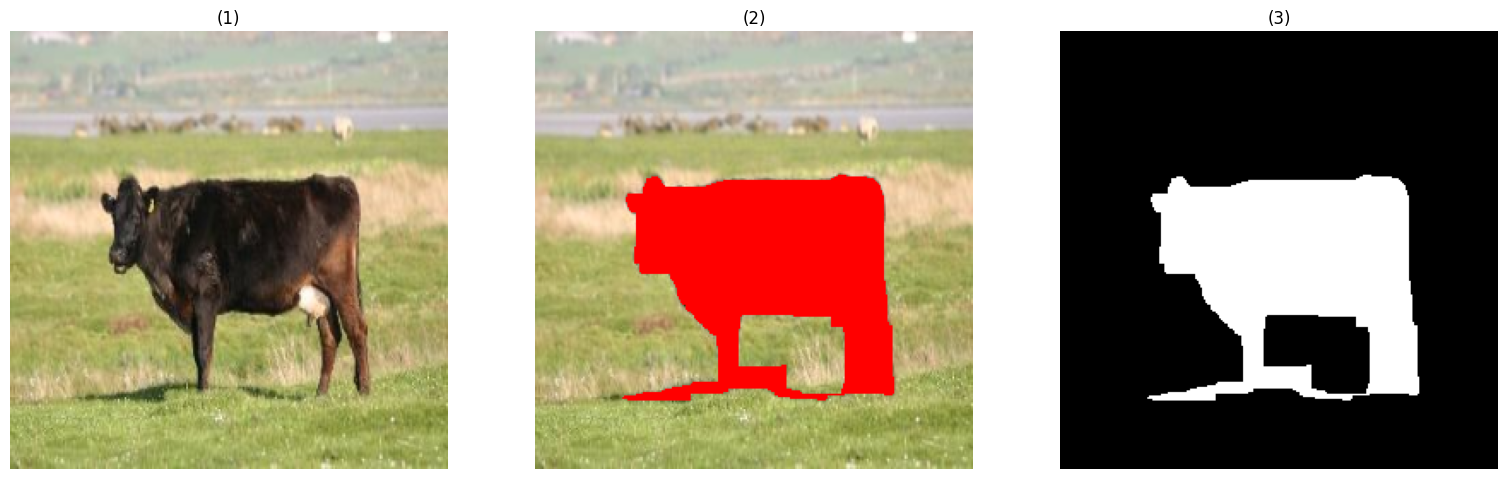

In [82]:
cow_select=io.imread('images-to-be-tested/cow_with_selection.png')
cow_orig=io.imread('images-to-be-tested/cow.jpg')

target_img_size = (256, 256)

cow_sel_resize = cv2.resize(cow_select, target_img_size)
cow_sel_conversion = rgba2rgb(cow_sel_resize)
cow_resized_orig = cv2.resize(cow_orig, target_img_size)


# # Create an instance of the RegionDetection class
region_detector_1 = RegionDetection(cow_resized_orig, cow_sel_conversion)
region_mask, binary_mask_test=region_detector_1.get_mask_by_region_detection()

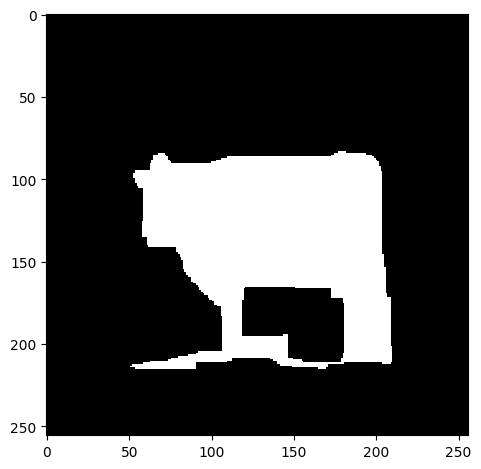

In [83]:
io.imshow(binary_mask_test)

In [84]:
def MSD(target_patch, exemplar_patch, M_bar):
    # if not np.isin(1,M_bar):
    #     return float('inf')
    if np.sum(M_bar)==0:
        return float('inf')
    else:
     msd=np.sum((M_bar*target_patch - M_bar*exemplar_patch)**2)/np.sum(M_bar)
     return msd
    # return msd

    # msd=np.sum((M_bar*target_patch - M_bar*exemplar_patch)**2)

    

def SMD (target_patch, exemplar_patch, binary_mask, M_bar):
    # if not np.isin(1,M_bar):
    #     return float('inf')
    if np.sum(M_bar)==0:
        return float('inf')
    if np.sum(binary_mask)==0:
        return float('inf')
    target_existing_avg= np.sum(M_bar * target_patch)/np.sum(M_bar)
    exemplar_fill_avg = np.sum(binary_mask* exemplar_patch)/np.sum(binary_mask)
    smd= (target_existing_avg-exemplar_fill_avg)**2
    return smd 

    # target_existing_avg= np.sum(M_bar * target_patch)
    # exemplar_fill_avg = np.sum(binary_mask* exemplar_patch)
    # smd= (target_existing_avg-exemplar_fill_avg)**2
    # return smd 

def findBestsubPatch(target_patch, exemplar_patches, binary_mask, M_bar):
    best_patch = exemplar_patches[len(exemplar_patches)-1]
    min_combined_error = float('inf')

    for other_patch in exemplar_patches:
        current_error = MSD((rgb2gray(target_patch)*255).astype('uint8'), (rgb2gray(other_patch)*255).astype('uint8'), M_bar) + SMD((rgb2gray(target_patch)*255).astype('uint8'), (rgb2gray(other_patch)*255).astype('uint8'), binary_mask, M_bar)
        # print(f"Current Error: {current_error}")

        if current_error < min_combined_error:
            best_patch = other_patch
            min_combined_error = current_error

    return best_patch


def findBestFullPatch(target_patches, exemplar_patches,binary_mask_patches, M_bar_patches):
    cp_target_patches = np.copy(target_patches)
    for i,target_patch in enumerate(target_patches):
        best_sub_patch=findBestsubPatch(target_patch,exemplar_patches,binary_mask_patches[i],M_bar_patches[i])
        cp_target_patches[i][binary_mask_patches[i] == 1] = best_sub_patch[binary_mask_patches[i] == 1]
    return cp_target_patches


In [85]:
def main(img,binary_mask, overlap=2):
    patch_size = 50
    img_in_patches= [img[i:i+patch_size,j:j+patch_size] for i in range(0,img.shape[0]-patch_size+1, overlap) for j in range(0,img.shape[1]-patch_size+1, overlap) ]
    full_binary_mask_patches = [binary_mask[i:i+patch_size,j:j+patch_size] for i in range(0,img.shape[0]-patch_size+1, overlap) for j in range(0,img.shape[1]-patch_size+1, overlap) ]
    #if the patch contains a single 1 then it's subset of the target patch so mark it with 1 in the bit map
    # bit_map=[ 1 if np.isin(1,full_binary_mask_patches[i]) else 0 for i in range(len(full_binary_mask_patches))]

    target_indices=[]
    exemplar_indices=[]
    binary_mask_patches= []
    target_patches=[]
    exemplar_patches=[]
    target_patch_counter=0
    patches_per_row = (img.shape[0] - patch_size) // overlap + 1
    patches_per_col = (img.shape[1] - patch_size) // overlap + 1
    for i, binary_mask_patch in enumerate(full_binary_mask_patches):

        start_row = (i // patches_per_row) * overlap
        start_col = (i % patches_per_row) * overlap
        if np.isin(1,binary_mask_patch):
            # This means that it is a target patch
            target_indices.append((target_patch_counter,start_row,start_col))
            binary_mask_patches.append(full_binary_mask_patches[i])
            target_patches.append(img_in_patches[i])
            target_patch_counter+=1
            # binary_mask_patches.append(binary_mask[start_row:start_row+patch_size])

        else:
            exemplar_indices.append((i, start_row, start_col))
            exemplar_patches.append(img_in_patches[i])


    # M_bar_patches=[np.where((binary_mask_patches[i]==0)|(binary_mask_patches[i]==1), binary_mask_patches[i]^1, binary_mask_patches) for i in range(len(binary_mask_patches))]
    M_bar_patches=[1-binary_mask_patches[i] for i in range(len(binary_mask_patches))]
    #TO-DO: call implemented functions
    new_target_patches=findBestFullPatch(target_patches,exemplar_patches,binary_mask_patches,M_bar_patches)
    print(len(new_target_patches))
    print(len(target_patches))
    print("new_target_patches",new_target_patches[0])
    print(new_target_patches[1])

    new_img= np.copy(img)
    for target_index, start_row, start_col in target_indices:
        print(target_index)
        new_img[start_row: start_row+patch_size, start_col:start_col+patch_size]=new_target_patches[target_index]
    
    return new_img

    # list of tuples (i,start_row,start_col)
    '''
    for target_index, start_row, start_col in target_indices:
        img[start_row:start_row+patch_size , start_col: start_col+patch_size]=cp_target_patches[target_index]
        start_row = (i // (img.shape[0] // patch_size)) * patch_size
        start_col = (i % (img.shape[1] // patch_size)) * patch_size
    
    '''




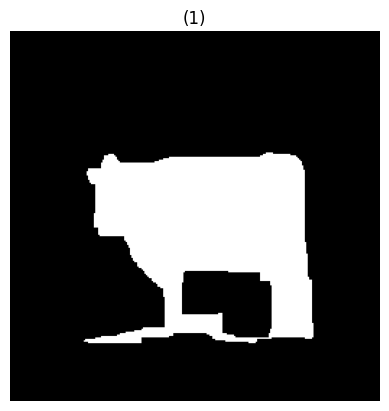

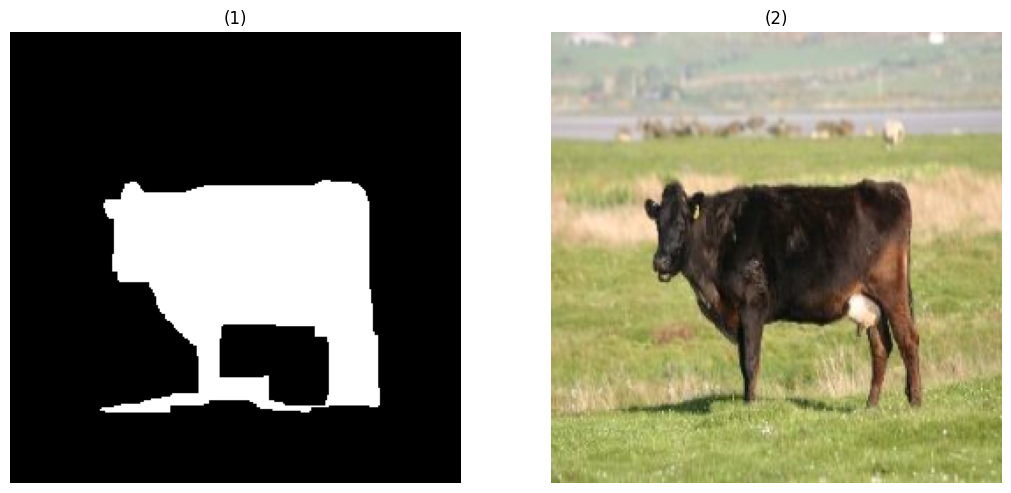

In [86]:
binary_mask_test=binary_mask_test[:,:,0]
show_images( [binary_mask_test])
grayLevelImg = cow_resized_orig#(rgb2gray(cow_resized_orig)*255).astype('uint8')
show_images( [binary_mask_test,grayLevelImg])

16
16
new_target_patches [[[193 180 174]
  [198 185 175]
  [205 192 180]
  ...
  [215 206 205]
  [218 207 206]
  [219 208 209]]

 [[187 174 166]
  [194 180 168]
  [195 180 166]
  ...
  [210 199 196]
  [213 201 198]
  [214 202 199]]

 [[185 171 162]
  [191 175 161]
  [181 165 148]
  ...
  [201 188 181]
  [201 189 181]
  [201 188 180]]

 ...

 [[202 177 138]
  [202 178 142]
  [192 171 138]
  ...
  [187 166 123]
  [198 175 133]
  [204 180 139]]

 [[208 182 144]
  [206 182 147]
  [191 170 139]
  ...
  [202 178 137]
  [208 184 143]
  [211 185 145]]

 [[216 188 151]
  [213 188 155]
  [205 181 152]
  ...
  [218 192 152]
  [220 194 154]
  [220 192 153]]]
[[[217 206 205]
  [211 200 196]
  [207 194 183]
  ...
  [205 203 204]
  [207 203 202]
  [209 203 198]]

 [[209 196 193]
  [199 186 180]
  [192 176 161]
  ...
  [202 200 201]
  [205 201 199]
  [206 199 193]]

 [[193 178 171]
  [181 166 155]
  [173 155 135]
  ...
  [203 201 201]
  [206 202 198]
  [205 197 189]]

 ...

 [[228 193 153]
  [227 192 

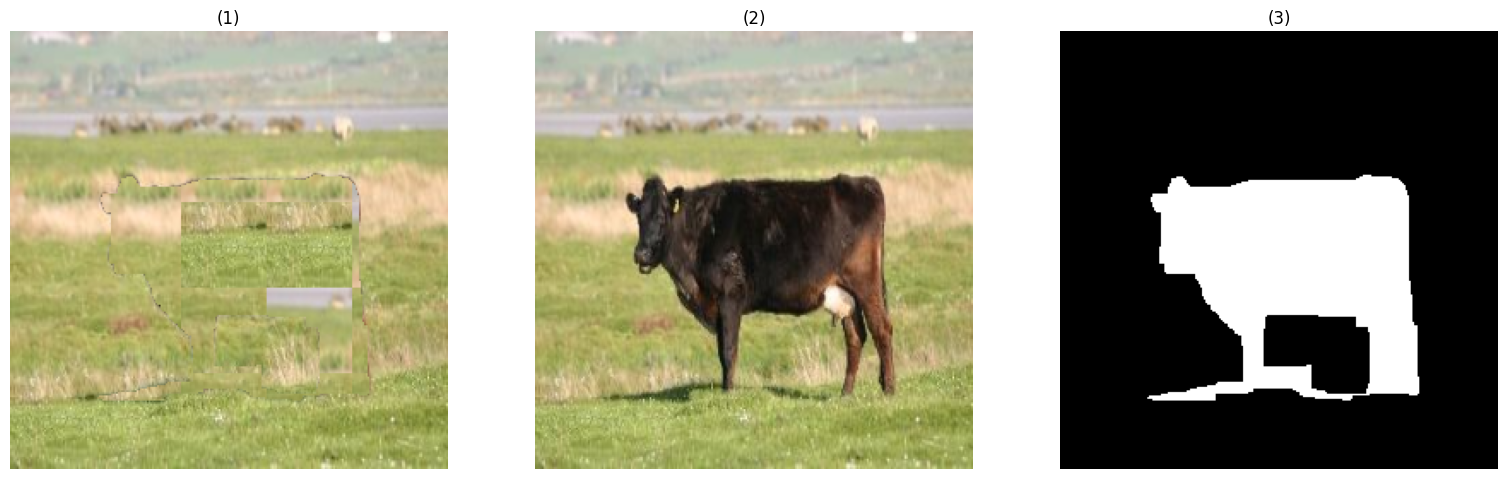

16
16
new_target_patches [[[193 180 174]
  [198 185 175]
  [205 192 180]
  ...
  [215 206 205]
  [218 207 206]
  [219 208 209]]

 [[187 174 166]
  [194 180 168]
  [195 180 166]
  ...
  [210 199 196]
  [213 201 198]
  [214 202 199]]

 [[185 171 162]
  [191 175 161]
  [181 165 148]
  ...
  [201 188 181]
  [201 189 181]
  [201 188 180]]

 ...

 [[202 177 138]
  [202 178 142]
  [192 171 138]
  ...
  [187 166 123]
  [198 175 133]
  [204 180 139]]

 [[208 182 144]
  [206 182 147]
  [191 170 139]
  ...
  [202 178 137]
  [208 184 143]
  [211 185 145]]

 [[216 188 151]
  [213 188 155]
  [205 181 152]
  ...
  [218 192 152]
  [220 194 154]
  [220 192 153]]]
[[[217 206 205]
  [211 200 196]
  [207 194 183]
  ...
  [205 203 204]
  [207 203 202]
  [209 203 198]]

 [[209 196 193]
  [199 186 180]
  [192 176 161]
  ...
  [202 200 201]
  [205 201 199]
  [206 199 193]]

 [[193 178 171]
  [181 166 155]
  [173 155 135]
  ...
  [203 201 201]
  [206 202 198]
  [205 197 189]]

 ...

 [[228 193 153]
  [227 192 

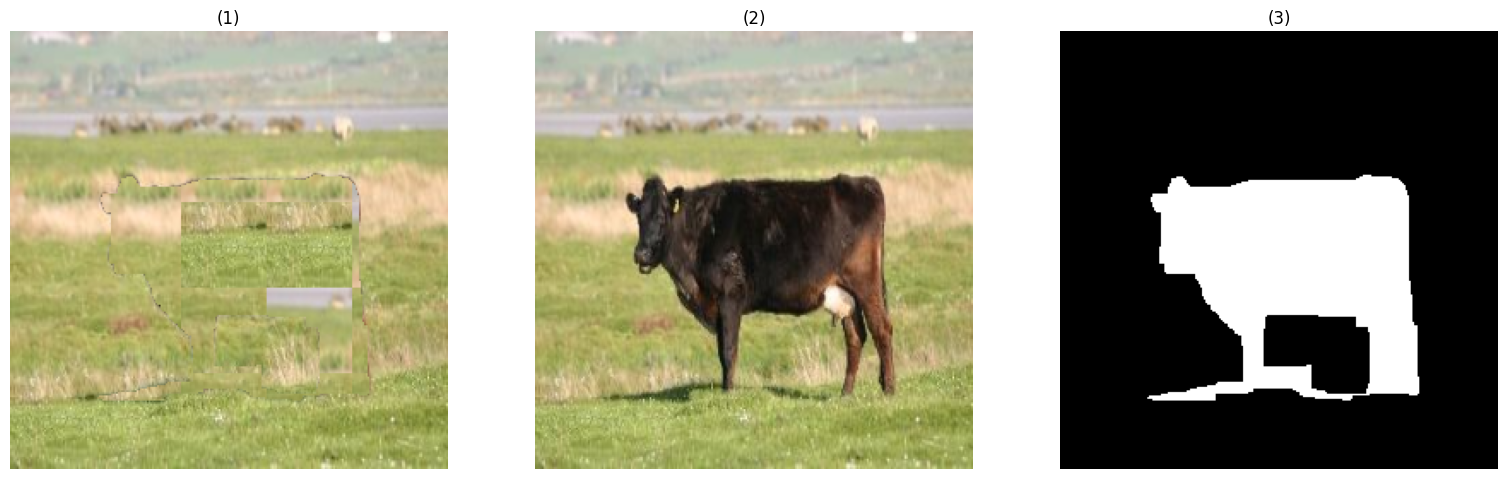

In [90]:

newImg= main(grayLevelImg,binary_mask_test, overlap=50)
show_images([newImg,grayLevelImg,   binary_mask_test])
Temp= main(newImg,binary_mask_test, overlap=50)
show_images([Temp,grayLevelImg,   binary_mask_test])

In [88]:
newImgOverlap2= main(grayLevelImg,binary_mask_test, overlap=4)
show_images([newImgOverlap2])

KeyboardInterrupt: 

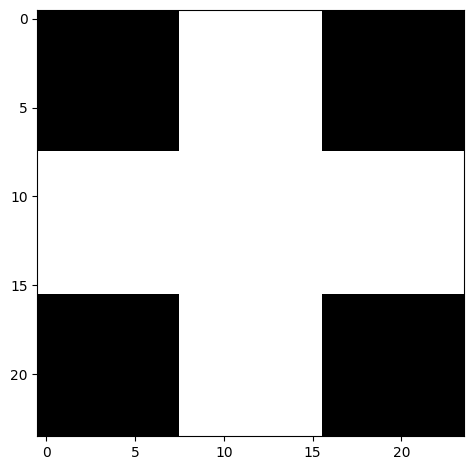

In [ ]:
img1=np.zeros((24,24))
img1=np.array([
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],

    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,],


    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],

])

img1=(img1*255).astype('uint8')
img1=255-img1
io.imshow(img1)

[[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1

C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\skimage\io\_plugins\matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


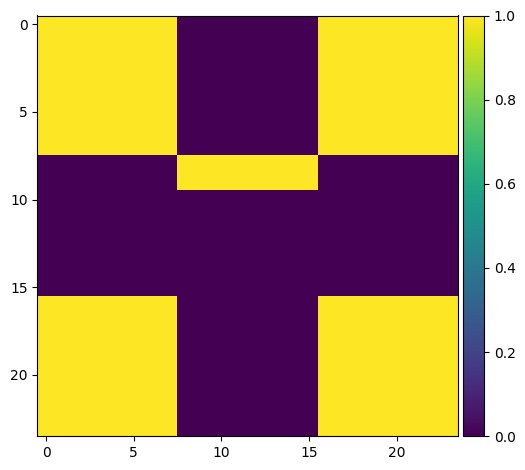

In [ ]:
img2=np.copy(img1)
img2=(img2*255).astype('uint8')
print(img2)
img3=1-img2
img3[8:10,8:16]=1
print(img3)
io.imshow(img3)


binary_mask_img2=np.zeros((24,24))
binary_mask_img2[8:12,8:16]=1

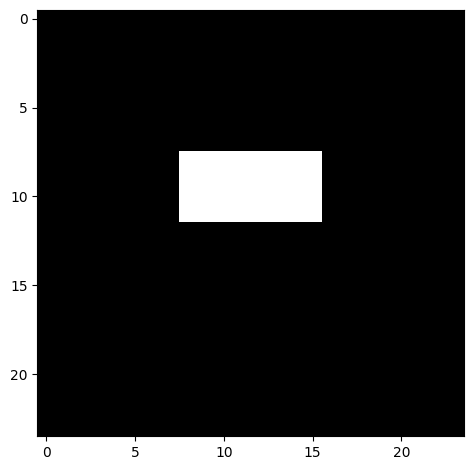

In [ ]:
io.imshow(binary_mask_img2)

In [ ]:
newImg2= main(img2,binary_mask_img2,overlap=8)
show_images([newImg2])

0
0


IndexError: index 0 is out of bounds for axis 0 with size 0